In [1]:
import numpy as np
from matplotlib import pyplot as plt

# A Minimal Active Inference Agent

## By André van Schaik

### __[International Centre for Neuromorphic Systems](https://westernsydney.edu.au/icns)__        15/12/2018

This notebook is based on __[a paper](https://arxiv.org/abs/1503.04187)__ with the same title by Simon McGregor, Manuel Baltieri and Christopher L. Buckley. 

I'm using it to investigate Karl Friston's Free Energy and Active Inference concepts. My notebook borrows heavily from one by __[Tomek Korbak](https://github.com/tomekkorbak/active-inference)__, but I didn't want to use anything but vanilla numpy and matplotlib, not tensorflow, etc., so I know exactly what is going on at each step.

The notebook simulates the agent described in the paper and illustrated below.

<img src="Agent.png" width="600">

To do so, we first define the functions as given in the paper:

In [2]:
def sensory_dynamics(psi):
    """
    P(s | psi)
    Probability of experiencing sensory state 1 given current position.
    """
    return MAX_SENSE_PROBABILITY * np.exp(-SENSE_DECAY_RATE * 
                np.minimum(np.abs(psi - FOOD_POSITION), np.abs(psi - FOOD_POSITION - ENV_SIZE)))


def model_encoding(b):
    """
    Probability of occupying specific position as encoded in the internal state.
    """
    # Softmax function. The shift by b.max() is for numerical stability
    return np.exp(b - b.max()) / np.sum(np.exp(b - b.max()))


def model_encoding_derivative(b):
    """
    Derivative of the model encoding for free energy gradient calculation
    """
    softmax_b = model_encoding(b)
    # Softmax derivative
    return np.diag(softmax_b) - np.outer(softmax_b, softmax_b)


def generative_density(b, a):
    """
    P(psi', s | b, a)
    Agent's prediction of its new position given its internal state and selected action
    (calculated separately for two sensory states).

    P(psi', s | b, a) = Sum_over_psi(P(psi' | s, b, a, psi) * P(s | b, a, psi) * P(psi | b, a))
                      = Sum_over_psi(P(psi' | a, psi) * P(s | psi) * P(psi | b))
                      
    since psi' only depends on a and psi, s only depends on psi, and psi only depends on b.

    """
    # sensory dynamics for each position: 
    """P(s | psi)"""
    sd = sensory_dynamics(np.arange(ENV_SIZE))
    
    """
    P(psi', s | b, a) = Sum_over_psi(P(psi' | a, psi) * P(s | psi) * P(psi | b))
    Note that the Sum_over_psi is only taken over the two positions psi that can result in getting to psi' given a
    """
    psi_prime_0 = ((1-MOVEMENT_PROBABILITY) * (1 - sd) * model_encoding(b) + 
                 MOVEMENT_PROBABILITY * np.roll((1 - sd) * model_encoding(b), a))

    psi_prime_1 = ((1-MOVEMENT_PROBABILITY) * sd * model_encoding(b) + 
                 MOVEMENT_PROBABILITY * np.roll(sd * model_encoding(b), a))
    
    return [psi_prime_0, psi_prime_1]


def variational_density(b):
    """
    P(psi | b)
    Agent's belief about the external states (i.e. its current position in the 
    world) or intention (i.e. desired position in the world) as encoded in the
    internal state.
    """
    return model_encoding(b)


def KL(a, b):
    """
    Kullback-Leibler divergence between densities a and b.
    """
    return np.sum(a * (np.log(a) - np.log(b)))


def free_energy(b_star, b, s, a):
    """
    KL divergence between variational density and generative density for a fixed
    sensory state s.
    """
    return KL(variational_density(b_star), generative_density(b, a)[s])


def fe_gradient(b_star, b, s, a):
    """
    Partial derivatives of the free energy with respect to belief R1.
    """
    J = model_encoding_derivative(b_star)
    Y = np.log(variational_density(b_star) / generative_density(b, a)[s])
    return np.dot(J,Y)

We also turn the pseudo-code from the paper into Python, and define a function for plotting the results:

In [3]:
def simulate_agent(psi, b, b_star):
    """
    Simulate the agent for EPOCHS steps.
    """
    # start trace at initial position
    psi_trace = [psi]
    
    # show the sensory dynamics given the food distribution at the left of the belief trace
    b_trace = [sensory_dynamics(np.arange(ENV_SIZE))]
    
    s_trace = []
    
    a_trace = []

    for epoch in range(EPOCHS):

        # Calculate sensory state s \in {0, 1}
        s = int(np.random.random() < sensory_dynamics(psi))

        # Pick action state, a \in {-1, 0, 1}
        # Calculate the free energy given my target (intent) distribution, current state distribution, & sensory input 
        # Do this for all (three) actions and select the action with minimum free energy.
        i = np.argmin((free_energy(b_star, b, s, -1), free_energy(b_star, b, s, 0), free_energy(b_star, b, s, 1)))
        a = (-1, 0, 1)[i]

        # Update actual position by taking action
        psi = (psi + a * (np.random.random() < MOVEMENT_PROBABILITY)) % ENV_SIZE

        # Update my internal state.
        # Start by creating a belief for my new position b_prime, from my belief for my previous position b
        # by mixing according to movement probability given action a:
        b_prime = MOVEMENT_PROBABILITY * np.roll(b, a) + (1 - MOVEMENT_PROBABILITY) * b
        # Note, this is not essential, as the minimisation below will update b_prime,
        # but it does provide a good starting point for gradient descent

        # Now minimise free energy
        for step in range(N_STEPS):
            b_prime -= LEARNING_RATE * fe_gradient(b_prime, b, s, a)

        # Save position, sensory output, and internal state for plotting
        b = b_prime
        s_trace.append(s)
        a_trace.append(a)
        psi_trace.append(psi)
        b_trace.append(model_encoding(b))

    # Show the target position as probability distribution at the right of the belief trace
    b_trace.append(model_encoding(b_star)) 
    s_trace.append(int(np.random.random() < sensory_dynamics(psi)))
    return (b_trace, psi_trace, s_trace, a_trace)


def plot_traces(b_trace, psi_trace, s_trace, a_trace):
    """
    Helper function for plotting agent's internal state and position.
    """
    fig = plt.figure(figsize=(15, 4))
    ax = fig.gca()
    im = ax.imshow(np.transpose(b_trace),
              interpolation="nearest", 
              aspect = "auto", 
              vmin = 0, vmax = 1, 
              cmap = "viridis")
    c = np.asarray(['white' if s==1 else 'grey' for s in s_trace])
    psi = np.asarray(psi_trace)
    epochs = np.arange(EPOCHS+1)
    a_trace.append(0)
    a = np.asarray(a_trace)
    idx = a<0
    ax.scatter(epochs[idx], psi[idx], c = c[idx], marker = 'v')
    idx = a>0
    ax.scatter(epochs[idx], psi[idx], c = c[idx], marker = '^')
    idx = a==0
    ax.scatter(epochs[idx], psi[idx], c = c[idx], marker = 'o')    
    ax.invert_yaxis()
    ax.set_xlim([0,EPOCHS+1])
    fig.colorbar(im)
    return fig

Now we are ready to run a simulation based on the parameters used in the paper. The numbers above the figure below indicate the probability for a HIGH sensor output at each of the 16 positions. Different from the paper, we give the agent a strong intention (defined by b_star) to be in position 3. 

[0.45850202 0.5        0.54525387 0.59460356 0.64841978 0.70710678
 0.77110541 0.84089642 0.91700404 0.84089642 0.77110541 0.70710678
 0.64841978 0.59460356 0.54525387 0.5       ]


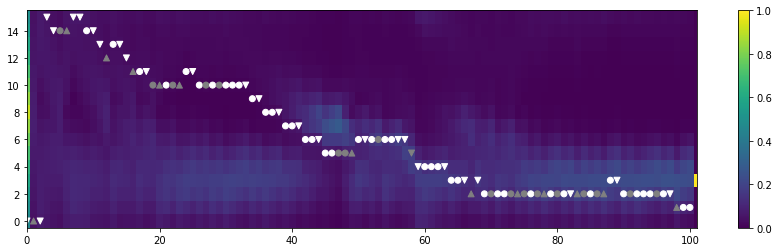

In [4]:
ENV_SIZE = 16
INITIAL_POSITION = 0
FOOD_POSITION = 8
MOVEMENT_PROBABILITY = 0.75

# Sensory dynamics parameters
MAX_SENSE_PROBABILITY = 4.0**(-1.0/16) # k
SENSE_DECAY_RATE = np.log(4)/16 # omega

# Position (external state), Psi \in (0,15)
psi = INITIAL_POSITION

# Internal state, R \in R^16
b = np.zeros(ENV_SIZE)

# Internal state (as intention), Ri \in R^16
TARGET_POSITION = 3
b_star = np.zeros(ENV_SIZE)
b_star[TARGET_POSITION] = 10 # strong preference for a single target position

# Simulation parameters
EPOCHS = 100                 # Number of epochs (simulation steps).
N_STEPS = 100                # Number of gradient descent steps made to update beliefs in each epoch.
LEARNING_RATE = 0.7          # Stochastic gradient descent learning rate

# Run simulation
(b_trace, psi_trace, s_trace, a_trace) = simulate_agent(psi, b, b_star)

# Plot output
fig = plot_traces(b_trace, psi_trace, s_trace, a_trace)

# Print sensory spike probability as a function of position
print(sensory_dynamics(np.arange(ENV_SIZE)))

In the figure above, the first column shows the starting position and the sensory probabilities. The final column shows the Intention State b_star, and the columns in between show how the agent's internal state evolves after each action. The colour bar indicates the probability for each position according to the agent's internal state. The markers indicate the agent's true position and are white if the sensor is HIGH or grey otherwise. The marker points down if a = -1, up if a = +1, and is round if a = 0.

Because the difference in HIGH sensory output is less than 5% between positions 3, 4, and 5, it is difficult for the agent to be certain where it is exactly, but it does a decent job staying around position 3.

We can simplify the situation for the agent, by having (near) deterministic movement and sensor response at the position with maximum food (position 8). In the example below we also drop the probability of sensory activation rapidly as a function of distance from position 8, and set the target position to 8.

[3.35127165e-04 9.10970084e-04 2.47627342e-03 6.73120905e-03
 1.82973232e-02 4.97372813e-02 1.35199948e-01 3.67511562e-01
 9.99000000e-01 3.67511562e-01 1.35199948e-01 4.97372813e-02
 1.82973232e-02 6.73120905e-03 2.47627342e-03 9.10970084e-04]


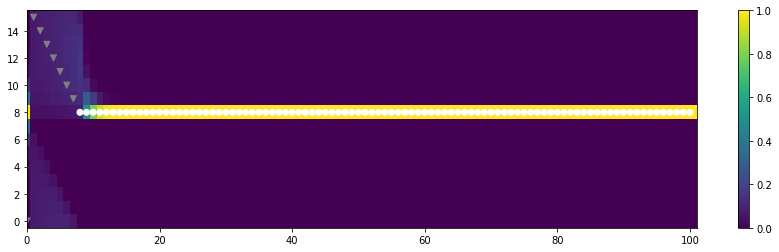

In [5]:
MOVEMENT_PROBABILITY = 0.999
MAX_SENSE_PROBABILITY = 0.999
SENSE_DECAY_RATE = 1
TARGET_POSITION = 8
FOOD_POSITION = 8

psi = INITIAL_POSITION
b = np.zeros(ENV_SIZE)
b_star = np.zeros(ENV_SIZE)
b_star[TARGET_POSITION] = 10

(b_trace, psi_trace, s_trace, a_trace) = simulate_agent(psi, b, b_star)

fig = plot_traces(b_trace, psi_trace, s_trace, a_trace)

print(sensory_dynamics(np.arange(ENV_SIZE)))

Clearly, the task is very simple here. Find the position where the sensor output is always HIGH and stay there.

It is slightly trickier to stay in another position, where the sensor doesn't always fire, although position 7 is still easy.

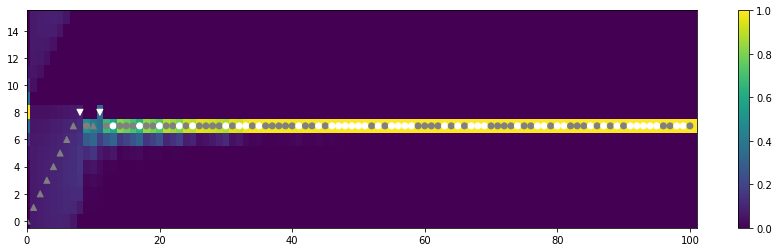

In [6]:
MOVEMENT_PROBABILITY = 0.999
MAX_SENSE_PROBABILITY = 0.999
SENSE_DECAY_RATE = 1
TARGET_POSITION = 7
FOOD_POSITION = 8

psi = INITIAL_POSITION
b = np.zeros(ENV_SIZE)
b_star = np.zeros(ENV_SIZE)
b_star[TARGET_POSITION] = 10

(b_trace, psi_trace, s_trace, a_trace) = simulate_agent(psi, b, b_star)

fig = plot_traces(b_trace, psi_trace, s_trace, a_trace)

With position 5 as a target, it becomes a little harder as the sensor is HIGH less than 5% of the time.

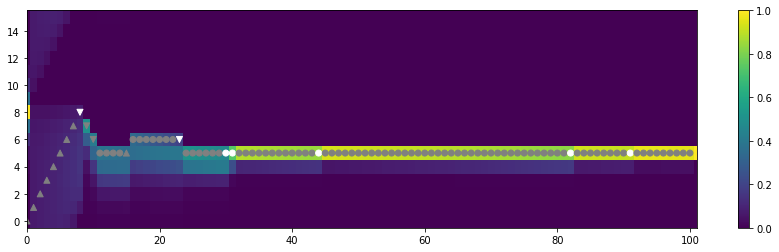

In [7]:
MOVEMENT_PROBABILITY = 0.999
MAX_SENSE_PROBABILITY = 0.999
SENSE_DECAY_RATE = 1
TARGET_POSITION = 5
FOOD_POSITION = 8

psi = INITIAL_POSITION
b = np.zeros(ENV_SIZE)
b_star = np.zeros(ENV_SIZE)
b_star[TARGET_POSITION] = 10

(b_trace, psi_trace, s_trace, a_trace) = simulate_agent(psi, b, b_star)

fig = plot_traces(b_trace, psi_trace, s_trace, a_trace)

And at position 0, and nearby positions, the sensor almost never fires, leaving the agent with little information about its position.

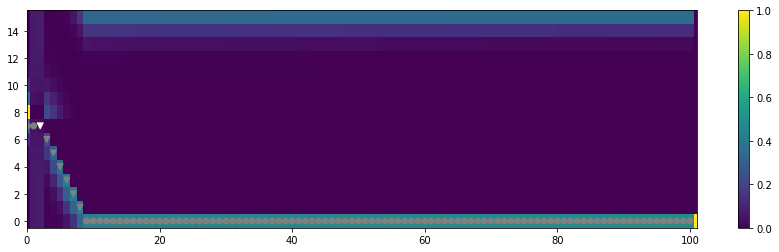

In [8]:
MOVEMENT_PROBABILITY = 0.999
MAX_SENSE_PROBABILITY = 0.999
SENSE_DECAY_RATE = 1
TARGET_POSITION = 0
FOOD_POSITION = 8

psi = INITIAL_POSITION+7
b = np.zeros(ENV_SIZE)
b_star = np.zeros(ENV_SIZE)
b_star[TARGET_POSITION] = 10

(b_trace, psi_trace, s_trace, a_trace) = simulate_agent(psi, b, b_star)

fig = plot_traces(b_trace, psi_trace, s_trace, a_trace)

With the original distribution of sensor probabilities, the agent receives more HIGH readings around position 0, but the same is true in neighbouring positions.

[0.45850202 0.5        0.54525387 0.59460356 0.64841978 0.70710678
 0.77110541 0.84089642 0.91700404 0.84089642 0.77110541 0.70710678
 0.64841978 0.59460356 0.54525387 0.5       ]


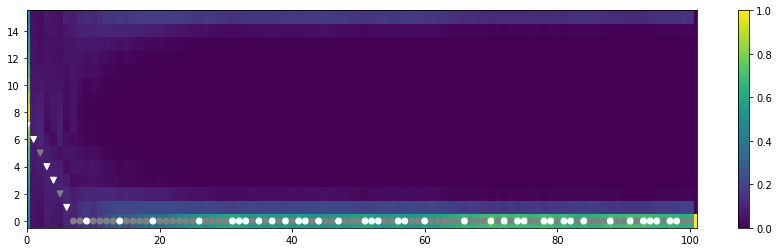

In [9]:
MOVEMENT_PROBABILITY = 0.999
MAX_SENSE_PROBABILITY = 4.0**(-1.0/16) # k
SENSE_DECAY_RATE = np.log(4)/16 # omega
TARGET_POSITION = 0
FOOD_POSITION = 8

psi = INITIAL_POSITION+7
b = np.zeros(ENV_SIZE)
b_star = np.zeros(ENV_SIZE)
b_star[TARGET_POSITION] = 10

(b_trace, psi_trace, s_trace, a_trace) = simulate_agent(psi, b, b_star)

fig = plot_traces(b_trace, psi_trace, s_trace, a_trace)

print(sensory_dynamics(np.arange(ENV_SIZE)))

And it is still an easy task when the target position is position 8 with maximum food.

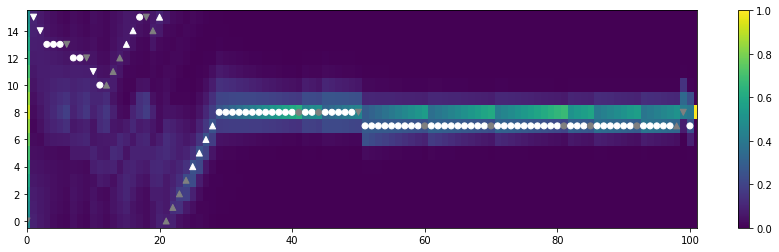

In [10]:
MOVEMENT_PROBABILITY = 0.999
MAX_SENSE_PROBABILITY = 4.0**(-1.0/16) # k
SENSE_DECAY_RATE = np.log(4)/16 # omega
TARGET_POSITION = 8
FOOD_POSITION = 8

psi = INITIAL_POSITION
b = np.zeros(ENV_SIZE)
b_star = np.zeros(ENV_SIZE)
b_star[TARGET_POSITION] = 10

(b_trace, psi_trace, s_trace, a_trace) = simulate_agent(psi, b, b_star)

fig = plot_traces(b_trace, psi_trace, s_trace, a_trace)

Lowering the movement probability makes it more likely that agent's MAP belief in its position doesn't correspond to its true position.

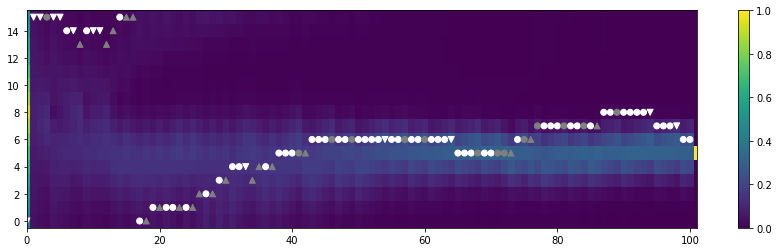

In [11]:
MOVEMENT_PROBABILITY = 0.5
MAX_SENSE_PROBABILITY = 4.0**(-1.0/16) # k
SENSE_DECAY_RATE = np.log(4)/16 # omega
TARGET_POSITION = 5
FOOD_POSITION = 8

psi = INITIAL_POSITION
b = np.zeros(ENV_SIZE)
b_star = np.zeros(ENV_SIZE)
b_star[TARGET_POSITION] = 10

(b_trace, psi_trace, s_trace, a_trace) = simulate_agent(psi, b, b_star)

fig = plot_traces(b_trace, psi_trace, s_trace, a_trace)

If we lower the level of intent for the target position, so the target density is less peaked, the agent wanders around more.

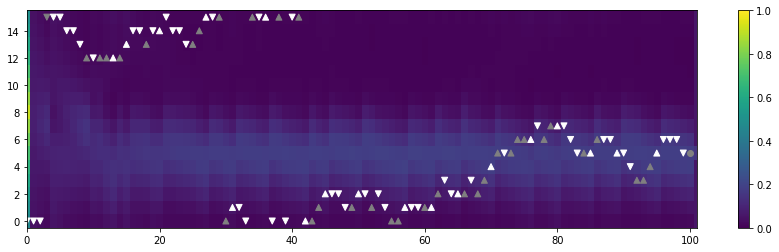

In [12]:
MOVEMENT_PROBABILITY = 0.5
MAX_SENSE_PROBABILITY = 4.0**(-1.0/16) # k
SENSE_DECAY_RATE = np.log(4)/16 # omega
TARGET_POSITION = 5
FOOD_POSITION = 8

psi = INITIAL_POSITION
b = np.zeros(ENV_SIZE)
b_star = np.zeros(ENV_SIZE)
b_star[TARGET_POSITION] = 1

(b_trace, psi_trace, s_trace, a_trace) = simulate_agent(psi, b, b_star)

fig = plot_traces(b_trace, psi_trace, s_trace, a_trace)

If we give the agent no preference for a particular position, i.e., have a flat intent density, actions are chosen to make the generative density as flat as possible. I don't yet understand what the resulting behaviour is.

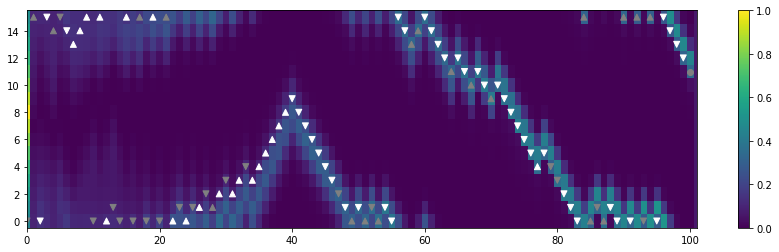

In [13]:
MOVEMENT_PROBABILITY = 0.99
MAX_SENSE_PROBABILITY = 0.99
SENSE_DECAY_RATE = .1
FOOD_POSITION = 8

psi = INITIAL_POSITION
b = np.zeros(ENV_SIZE)
b_star = np.zeros(ENV_SIZE)

(b_trace, psi_trace, s_trace, a_trace) = simulate_agent(psi, b, b_star)

fig = plot_traces(b_trace, psi_trace, s_trace, a_trace)

In conclusion, the agent behaviour is as follows:

* Get sensor output `s` at current position;
* Pick an action `a` that minimises the KL divergence between the target (Intent) density `b_star` and the generative density. The latter generates a joint probability for the next position `psi_prime` and current sensor observation `s`, depending on the agent's belief about its current position `b` and the actions `a` that are being considered;
* Update position `psi` by taking action `a` with probability `MOVEMENT_PROBABILITY`;
* Minimise the KL divergence between the new internal state `b_prime` for the next position and the generative density for the chosen action `a` and internal state `b`;
* Update internal state `b` with `b_prime`;
* Repeat.


___
One of the issues with the approach above is that it introduces arbitrary LEARNING_RATE and N_STEPS parameters, which are used for the Gradient Descent optimisation. Below I import the `minimize` function from the `optimize` module in the `scipy` package. 

In [14]:
from scipy.optimize import minimize
ACTUAL_MOVEMENT_PROBABILITY = MOVEMENT_PROBABILITY
def simulate_agent_scipy(psi, b, b_star):
    """
    Simulate the agent for EPOCHS steps.
    """
    # start trace at initial position
    psi_trace = [psi]
    
    # show the sensory dynamics given the food distribution at the left of the belief trace
    b_trace = [sensory_dynamics(np.arange(ENV_SIZE))]
    
    s_trace = []
    
    a_trace = []

    for epoch in range(EPOCHS):

        # Calculate sensory state s \in {0, 1}
        s = int(np.random.random() < sensory_dynamics(psi))

        # Pick action state, a \in {-1, 0, 1}
        # Calculate the free energy given my target (intent) distribution, current state distribution, & sensory input 
        # Do this for all (three) actions and select the action with minimum free energy.
        i = np.argmin((free_energy(b_star, b, s, -1), free_energy(b_star, b, s, 0), free_energy(b_star, b, s, 1)))
        a = (-1, 0, 1)[i]

        # Update actual position by taking action
        psi = (psi + a * (np.random.random() < ACTUAL_MOVEMENT_PROBABILITY)) % ENV_SIZE

        # Update my internal state.
        # Start by creating a belief for my new position b_prime, from my belief for my previous position b
        # by mixing according to movement probability given action a:
        b_prime = MOVEMENT_PROBABILITY * np.roll(b, a) + (1 - MOVEMENT_PROBABILITY) * b
        # Note, this is not essential, as the minimisation below will update b_prime,
        # but it does provide a good starting point for gradient descent

        # Now minimise free energy
        b_prime = minimize(free_energy, b_prime, args=(b, s, a), method = METHOD, jac=fe_gradient)['x']

        # Save position, sensory output, and internal state for plotting
        b = b_prime
        s_trace.append(s)
        a_trace.append(a)
        psi_trace.append(psi)
        b_trace.append(model_encoding(b))

    # Show the target position as probability distribution at the right of the belief trace
    b_trace.append(model_encoding(b_star)) 
    s_trace.append(int(np.random.random() < sensory_dynamics(psi)))
    return (b_trace, psi_trace, s_trace, a_trace)

Below I use the Method of Conjugate Gradients for optimisation. (I have another set of notebooks about this topic __[here](https://github.com/vschaik/Conjugate-Gradient)__. For using this method, you don't even have to know the derivatives of your function, but if you do know them (`fe_gradient`), the optimisation will run much faster by providing this as a separate input to the `minimize` function. 

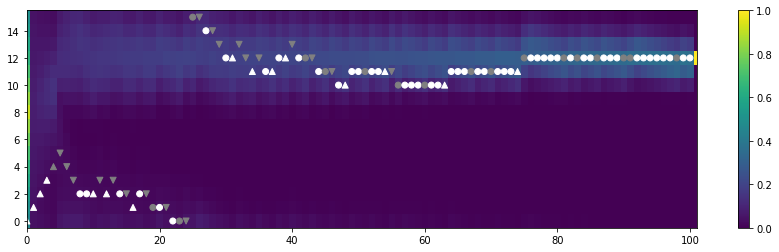

In [15]:
MOVEMENT_PROBABILITY = 0.75
MAX_SENSE_PROBABILITY = 4.0**(-1.0/16) # k
SENSE_DECAY_RATE = np.log(4)/16 # omega
TARGET_POSITION = 12
FOOD_POSITION = 8

psi = INITIAL_POSITION
b = np.zeros(ENV_SIZE)
b_star = np.zeros(ENV_SIZE)
b_star[TARGET_POSITION] = 10

METHOD = 'CG' # Optimisation method. See scipy.optimize.minimize for documentation
(b_trace, psi_trace, s_trace, a_trace) = simulate_agent_scipy(psi, b, b_star)

fig = plot_traces(b_trace, psi_trace, s_trace, a_trace)

We now have no free parameters in our system - just those that define the environment, the model for sensory dynamics, and the probability that an action to move in a direction actually results in a move (`MOVEMENT_PROBABILITY`). The only catch with this is that the generative density, which the agent needs to calculate its variational free energy, is known exactly by the agent. In reality, it would seem that an agent would need to learn this parameter from experience, rather than take it as a given. Thus, to investigate this, I have also introduced in the function above the `ACTUAL_MOVEMENT_PROBABILITY` constant, which is a probability in the external world.

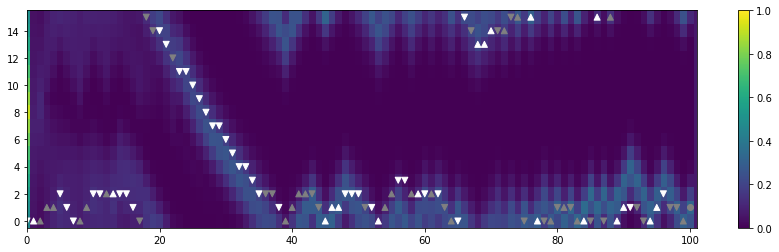

In [16]:
ACTUAL_MOVEMENT_PROBABILITY = 0.5
MOVEMENT_PROBABILITY = 0.95
MAX_SENSE_PROBABILITY = 4.0**(-1.0/16) # k
SENSE_DECAY_RATE = np.log(4)/16 # omega
FOOD_POSITION = 8

psi = INITIAL_POSITION
b = np.zeros(ENV_SIZE)
b_star = np.zeros(ENV_SIZE)

METHOD = 'CG' # Optimisation method. See scipy.optimize.minimize for documentation
(b_trace, psi_trace, s_trace, a_trace) = simulate_agent_scipy(psi, b, b_star)

fig = plot_traces(b_trace, psi_trace, s_trace, a_trace)

ACTUAL_MOVEMENT_PROBABILITY = 0.75
MOVEMENT_PROBABILITY = 0.75

As we can see in the above example, if the agent assumes the wrong movement probability, it will estimate its position wrongly. Unfortunately, it would complicate the current example too much and involve simulation durations that would be too long to allow the agent to learn `MOVEMENT_PROBABILITY` from experience. The only strategy I can think of is for the agent to collect statistics for sensory activation for many time steps without moving. Then initiate an action and collect the statistics again. If these haven't changed, assume the action did not result in motion, and try again. This way the agent can build up a model of its (long term) sensory statistics at each point in its environment, and thus learn where it is. Once it knows that, it can determine how often the statistics change as expected for each action it can take, and thus learn its `MOVEMENT_PROBABILITY`. This would be very slow, and it is unclear how this would be formulated using an intent distribution `b_star`. It would be much quicker if the sensory response was a continuous function of position (plus added zero mean noise), in which case an estimate of sensory response and its derivative as a function of position can be obtained much more quickly.

Other active inference agents by the same authors:

Braitenberg style agents doing phototaxis. __[Manuel Baltieri, and Christopher Buckley (2017) "An active inference implementation of phototaxis"](http://sro.sussex.ac.uk/71872/)__.

An extensive mathematical foundation for Variational Free Energy and Active Inference __[C. L. Buckley, C. S. Kim, S. Mcgregor and A. K. Seth. (2017) "The free energy principle for action and perception: A mathematical review"](https://www.sciencedirect.com/science/article/pii/S0022249617300962)__. The paper contains Matlab code for a temperature controlling agent minimising Free Energy, and clarifies a framework for a hierarchical model that can learn the generative densities.